# import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
import os
%matplotlib inline

# functions

## Equal State

In [2]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state+1)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate, edges

## PIfunc

In [3]:
def PIfunc(r, x, v, dt, window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
    Information = dict()
    Information[('BROJA_2PID','SI')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIx')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIv')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','CI')]=np.zeros(len(bitshift))
    Information[('Beer','Red')]=np.zeros(len(bitshift))
    Information[('Beer','UIx')]=np.zeros(len(bitshift))
    Information[('Beer','UIv')]=np.zeros(len(bitshift))
    Information[('Beer','Syn')]=np.zeros(len(bitshift))
    
    Information[('test','SI')]=np.zeros(len(bitshift))
    Information[('test','UIx')]=np.zeros(len(bitshift))
    Information[('test','UIv')]=np.zeros(len(bitshift))
    Information[('test','CI')]=np.zeros(len(bitshift))
    Redun =np.zeros(len(bitshift))
    MIxr=np.zeros(len(bitshift))
    MIvr=np.zeros(len(bitshift))
    MIxvR=np.zeros(len(bitshift))
    parms = dict()
    parms['max_iters'] = 20
    # shifted data
    # shift>0 => y shifted to positive side
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            rr=r[:(-1*shift)]
        elif shift==0:
            xx=x
            vv=v
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            rr=r[(-1*shift):]
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(xx),(max(xx)+1))
        vedges = np.append(np.unique(vv),(max(vv)+1))
        redges = np.append(np.unique(rr),(max(rr)+1))
        dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
        N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
        #Calculate all kinds of probability and make sure the shape of them, 0 -> x, 1 -> v, 2 -> r
        px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
        pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
        pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
        pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
        pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
        pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
        pxvr=(N/np.sum(N))
        
        Information[('test','UIx')][i] = np.nansum(pxvr*np.log2(pxvr*px/pxv/pxr))/dt
        Information[('test','UIv')][i] = np.nansum(pxvr*np.log2(pxvr*pv/pxv/pvr))/dt
                
#         PDF=Histo3D2Dict(pxvr)
#         BROJA_2PID = pid(PDF, cone_solver="ECOS", output=0, **parms)
#         Information[('BROJA_2PID','SI')][i]=BROJA_2PID['SI']/dt
#         Information[('BROJA_2PID','UIx')][i]=BROJA_2PID['UIY']/dt
#         Information[('BROJA_2PID','UIv')][i]=BROJA_2PID['UIZ']/dt
#         Information[('BROJA_2PID','CI')][i]=BROJA_2PID['CI']/dt
        

        MIxr=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        MIvr=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
        MIxvR=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
        PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
        PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
        R = sum(np.minimum(PI_xR, PI_vR))/dt
        Information[('Beer','Red')][i] = R
        Information[('Beer','UIx')][i] = MIxr - R
        Information[('Beer','UIv')][i] = MIvr - R
        Information[('Beer','Syn')][i] = MIxvR - MIxr - MIvr + R

    return timeshift, Information

## Spike_Time_Generator

In [4]:
def Spike_Time_Generater(rdt, dt, Garmma=1):
    rdt = rdt*Garmma
    Spike_time = []
    
    counter = 0
    post_remainer_c = 0
    p = 1
    while True:
        the_random_number = np.random.rand()
        while (the_random_number < p and counter < len(rdt)):
            p *= np.exp(-rdt[counter])
            counter += 1
        if counter >= len(rdt):
            break
        remainer_c = -np.log(p/the_random_number)/rdt[counter-1]
#         if remainer_c>=1 or remainer_c<=0:
#             print('shit!')
        Spike_time.append(dt*(counter-remainer_c))
        p = np.exp(-remainer_c*rdt[counter-1])
    return Spike_time[::Garmma]

## activation function

In [5]:
# activation function
def NL(x,theta=0):
    y = np.zeros(len(x))
    for i in range(len(x)):
        if x[i]- theta>0:
            y[i]= x[i]-theta
    return(y)

# Main

In [6]:
dt = 0.01
Tot=300
T=np.arange(dt,Tot,dt)
OX = 'RN'
# OX = 'OU'

In [7]:
if OX == 'RN':
    D = 27*10**5
    RN=np.zeros(len(T))
    mu, sigma = 0, 1
    RN=np.random.normal(mu,sigma,size = (len(T)))
    RN = (RN-np.mean(RN))/np.std(RN)
    x_list = [RN.copy()]
    Gsigma_list = np.arange(0,102,10)
    for i in np.arange(1,len(Gsigma_list)):
        x = ndimage.gaussian_filter1d(RN, sigma=Gsigma_list[i])
        x = x.astype(float)
        x_list.append(x.copy())
    
    
elif OX == 'OU':
    # OU ; input
    tau= 1
    D = 27*10**5
    OU=np.zeros(len(T))
    mu, sigma = 0, 1
    for i in range(len(T)-1):
        OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    OU = (OU-np.mean(OU))/np.std(OU)

    # filtering for OUSmoothed
    x_list = []
    Fc_list = 2**np.arange(-1.,4.,1.)
    for Fc in Fc_list:
        b, a = signal.butter(2, 2*Fc*dt, btype='low', analog=False)
        x = signal.filtfilt(b, a, OU)
        x = x.astype(float)
        x_list.append(x.copy())
    Fc_list = np.append(Fc_list, 4*Fc_list[-1])
    x_list.append(OU)

0.005

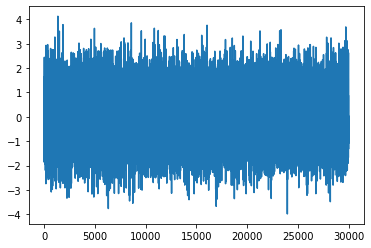

In [8]:
# plt.plot(RN)
# x_cor = np.correlate(RN, RN, "same")
# x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
# Taxis = np.flip(T[:len(x_cor)]-dt/2)
# round(np.interp(0.5*max(x_cor),  x_cor, Taxis), 3)

In [9]:
xt_cor_list = []
vt_cor_list = []
xvt_cor_list = []
v_list = []
xstate_list = []
vstate_list = []
r_list = []
Lambda = 0.45
Gsigma_list = np.arange(1,102,10)
for i in range(len(x_list)):
    x = x_list[i].copy()
#     v = ndimage.gaussian_filter1d(x.copy(), sigma=1, order=1, mode='reflect') / dt
    v = np.append(0,(np.diff(x)/dt))
    v_list.append(v.copy())
    
    r = (1-Lambda)*x+Lambda*v
    r_list.append(r.copy())
    
    xstate, _= EqualState(x, 6)
    vstate, _= EqualState(v, 6)
    xstate_list.append(xstate.copy())
    vstate_list.append(vstate.copy())

    x_cor = np.correlate(x, x, "same")
    x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
    Taxis = np.flip(T[:len(x_cor)]-dt/2)
    xt_cor_list.append(round(np.interp(0.5*max(x_cor),  x_cor, Taxis), 5))
    x_cor = np.correlate(v, v, "same")
    x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
    Taxis = np.flip(T[:len(x_cor)]-dt/2)
    vt_cor_list.append(round(np.interp(0.5*max(x_cor),  x_cor, Taxis), 5))
    xv_cor = np.correlate(x, v, "same")
    xvt_cor_list.append(np.abs(np.argmax(xv_cor)-np.argmin(xv_cor))*dt)


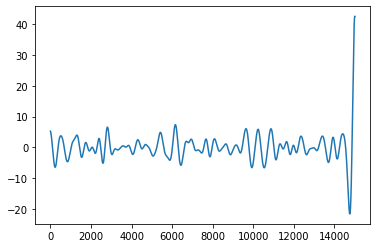

In [10]:
plt.plot(x_cor)

In [11]:
t_cor_list = xt_cor_list

## correlation time

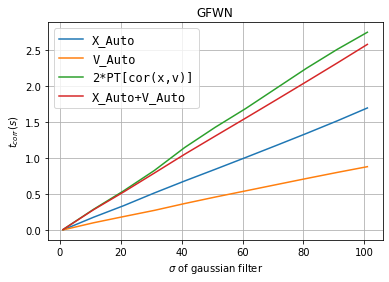

In [12]:
if OX == 'RN':
    plt.plot(Gsigma_list,xt_cor_list)
    plt.plot(Gsigma_list,vt_cor_list)
    plt.plot(Gsigma_list,xvt_cor_list)
    plt.plot(Gsigma_list,np.array(vt_cor_list)+np.array(xt_cor_list))
    plt.title('GFWN')
    plt.grid()
    plt.xlabel(r'$\sigma$ of gaussian filter')
    plt.ylabel(r'$t_{corr} (s)$')
    plt.legend( ('X_Auto', 'V_Auto', '2*PT[cor(x,v)]', 'X_Auto+V_Auto'), loc='best', prop={'size': 'large', 'family': 'monospace'})
elif OX == 'OU':
    plt.plot(Fc_list[:-1],xt_cor_list[:-1])
    plt.plot(Fc_list[:-1],vt_cor_list[:-1])
    plt.plot(Fc_list[:-1],xvt_cor_list[:-1])
    plt.plot(Fc_list[:-1],np.array(vt_cor_list[:-1])+np.array(xt_cor_list[:-1]))
    plt.title('LPOU')
    plt.grid()
    plt.xlabel(r'$F_c$')
    plt.ylabel(r'$t_{corr} (s)$')
    plt.legend( ('X_Auto', 'V_Auto', '2*PT[cor(x,v)]', 'X_Auto+V_Auto'), loc='best', prop={'size': 'large', 'family': 'monospace'})


In [13]:
rstate_list = []
for i in range(len(x_list)):
    r = r_list[i]
    cr = NL(-np.mean(r)+r, 0)
    ratio = sum(cr)/Tot/12
    cFakeSpike = Spike_Time_Generater(cr/ratio, dt, 10)
    crstate,_  = np.histogram(cFakeSpike, np.append(0,T))
    rstate_list.append(crstate.copy())
#     plt.plot(crstate)
#     plt.plot(cr/max(cr))

In [14]:
# for i in np.arange(1,len(x_list)):
#     r = r_list[i]
#     plt.plot(np.sort(r))
# plt.gcf().set_size_inches(8,4*(np.sqrt(5)-1))

## PID

In [15]:
window = [-1,1] # second
Information_list = [0]*len(x_list)
for i in range(len(x_list)):
    timeshift, Information_list[i] = PIfunc(rstate_list[i], xstate_list[i], vstate_list[i], dt, window)

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered i

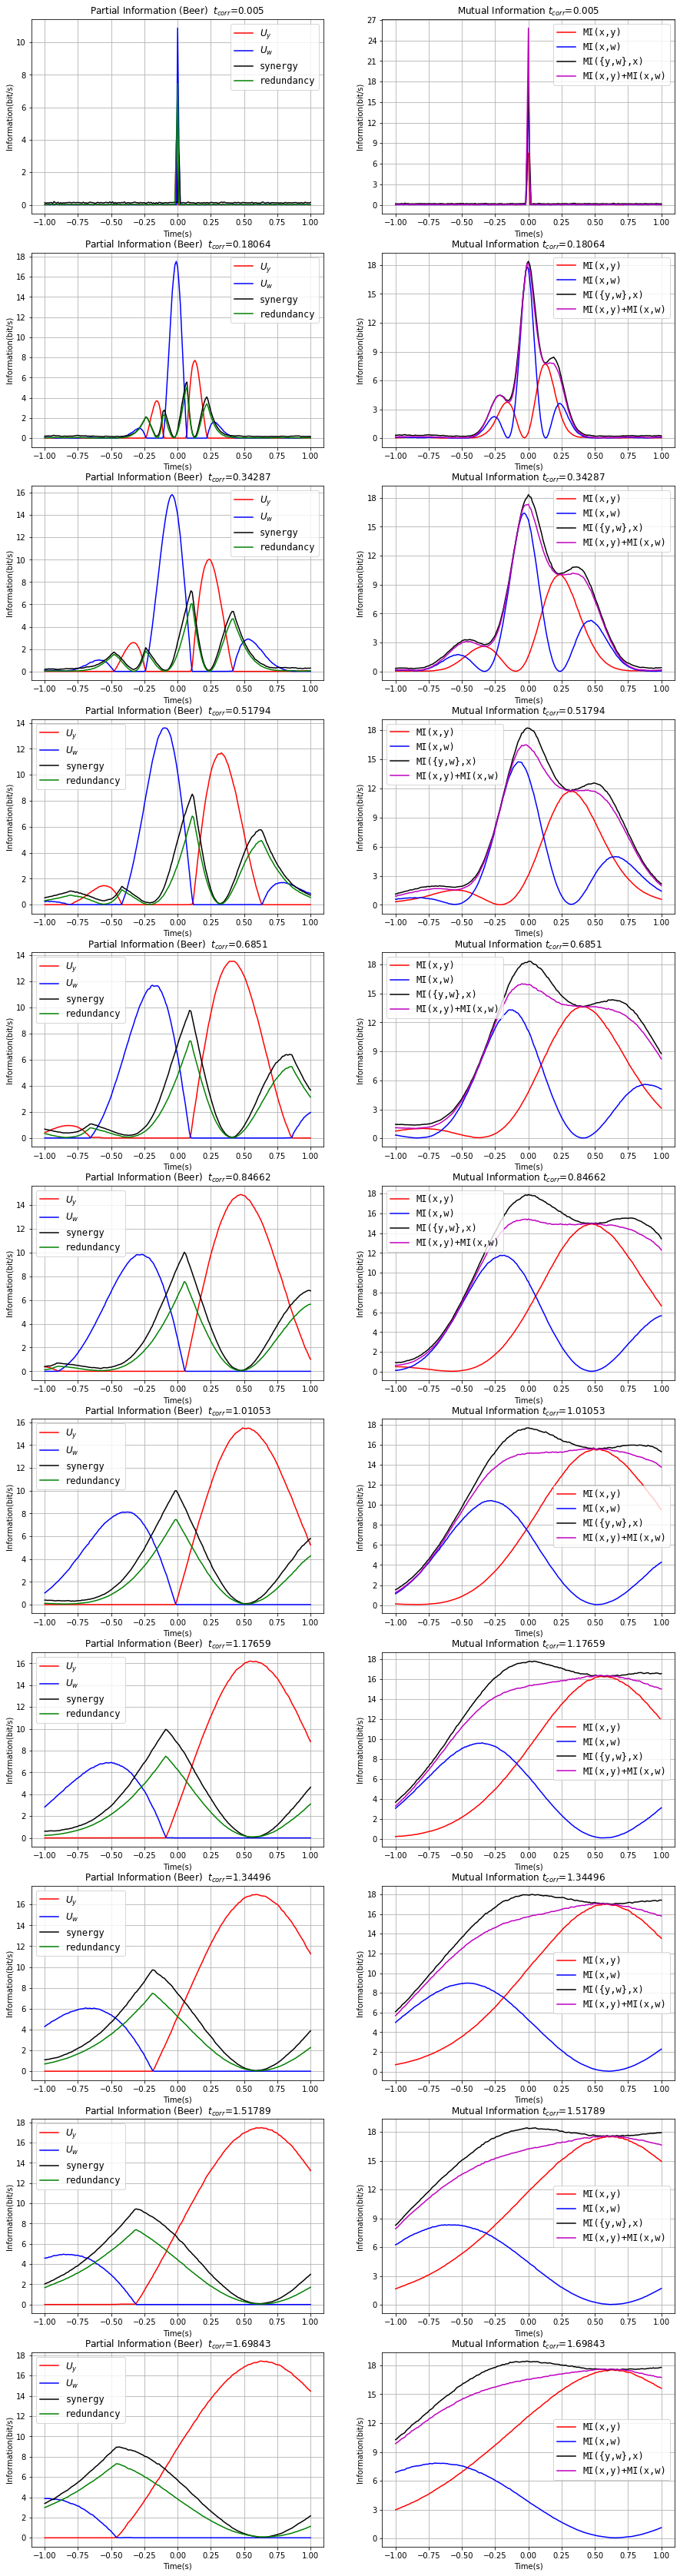

In [16]:
fig, ax = plt.subplots(nrows=len(x_list), ncols=2)
for i in range(len(x_list)): 
    ax[i][0].plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
    ax[i][0].plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
    ax[i][0].plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
    ax[i][0].plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
    ax[i][0].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[i][0].set_title('Partial Information (Beer)  '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax[i][0].set_xlabel('Time(s)')
    ax[i][0].set_ylabel('Information(bit/s)')
    ax[i][0].legend( (r'$U_y$', r'$U_w$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax[i][0].grid()
    
    #plot MIs
    ax[i][1].plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
    ax[i][1].plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
    ax[i][1].plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
    ax[i][1].plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
    ax[i][1].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[i][1].set_title('Mutual Information '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax[i][1].set_xlabel('Time(s)')
    ax[i][1].set_ylabel('Information(bit/s)')
    ax[i][1].grid()
    ax[i][1].legend( ('MI(x,y)', 'MI(x,w)', 'MI({y,w},x)', 'MI(x,y)+MI(x,w)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
fig.set_size_inches(15, 5.5*len(x_list))

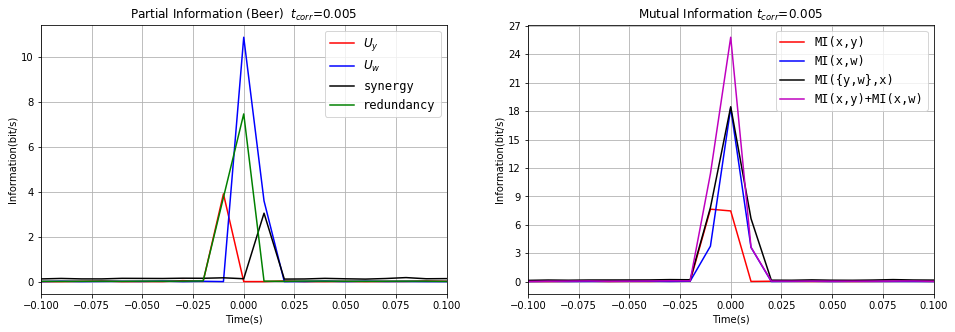

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2)
i=0
ax[0].plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
ax[0].plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
ax[0].plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
ax[0].plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
ax[0].yaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set_title('Partial Information (Beer)  '+r'$t_{corr}$='+str(t_cor_list[i]))
ax[0].set_xlabel('Time(s)')
ax[0].set_ylabel('Information(bit/s)')
ax[0].set_xlim([-0.1,0.1])
ax[0].legend( (r'$U_y$', r'$U_w$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax[0].grid()

#plot MIs
ax[1].plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
ax[1].plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
ax[1].plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
ax[1].plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
ax[1].yaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].set_title('Mutual Information '+r'$t_{corr}$='+str(t_cor_list[i]))
ax[1].set_xlabel('Time(s)')
ax[1].set_ylabel('Information(bit/s)')
ax[1].set_xlim([-0.1,0.1])
ax[1].grid()
ax[1].legend( ('MI(x,y)', 'MI(x,w)', 'MI({y,w},x)', 'MI(x,y)+MI(x,w)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
plt.gcf().set_size_inches(16,4*(np.sqrt(5)-1))

## Properties of Information curves

In [18]:
UIx_peaktime = []
UIv_peaktime = []
Syn_peaktime = []
Rdn_peaktime = []
UIx_peak = []
UIv_peak = []
Syn_peak = []
Rdn_peak = []

MIx_peaktime = []
MIv_peaktime = []
MIxv_peaktime = []
MIx_peak = []
MIv_peak = []
MIxv_peak = []
for i in range(len(x_list)): 
    UIx_peaktime.append( timeshift[np.argmax(Information_list[i][('Beer','UIx')])] )
    UIv_peaktime.append( timeshift[np.argmax(Information_list[i][('Beer','UIv')])] )
    Syn_peaktime.append( timeshift[np.argmax(Information_list[i][('Beer','Syn')])] )
    Rdn_peaktime.append( timeshift[np.argmax(Information_list[i][('Beer','Red')])] )
    UIx_peak.append( max(Information_list[i][('Beer','UIx')]) )
    UIv_peak.append( max(Information_list[i][('Beer','UIv')]) )
    Syn_peak.append( max(Information_list[i][('Beer','Syn')]) )
    Rdn_peak.append( max(Information_list[i][('Beer','Red')]) )

    MIx_peaktime.append( timeshift[np.argmax(Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')])])
    MIv_peaktime.append( timeshift[np.argmax(Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')])])
    MIxv_peaktime.append( timeshift[np.argmax(Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Syn')]+Information_list[i][('Beer','Red')])])
    MIx_peak.append( max(Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]))
    MIv_peak.append( max(Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')]))
    MIxv_peak.append( max(Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Syn')]+Information_list[i][('Beer','Red')]))

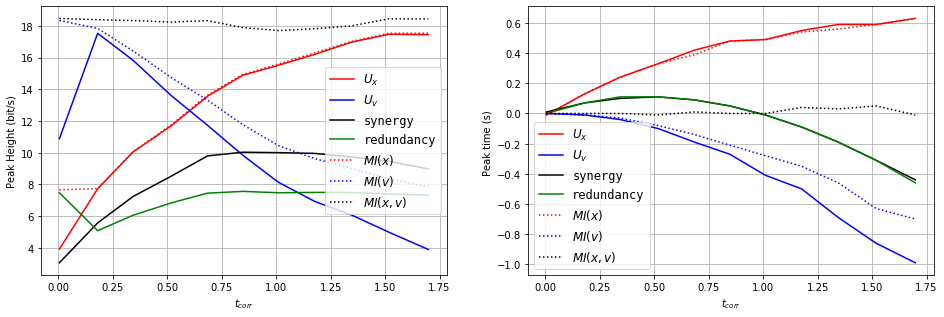

In [19]:

fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
fig.set_size_inches(16, 4*(np.sqrt(5)-1))
#     fig.suptitle(r'$F_c = $'+ str(Fc_list[i]/2)+'Hz,  '+r'$t_{corr}=$'+str(round(t_cor_list[i],3))+'s',y =0.95)
ax2.plot(t_cor_list, UIx_peak, 'r-')
ax2.plot(t_cor_list, UIv_peak, 'b-')
ax2.plot(t_cor_list, Syn_peak, 'k-')
ax2.plot(t_cor_list, Rdn_peak, 'g-')

ax2.plot(t_cor_list, MIx_peak, 'r:')
ax2.plot(t_cor_list, MIv_peak, 'b:')
ax2.plot(t_cor_list, MIxv_peak, 'k:')
ax2.set_xlabel(r'$t_{corr}$ ')
ax2.set_ylabel(r'Peak Height (bit/s)')
ax2.grid(True)
ax2.legend((r'$U_x$', r'$U_v$', 'synergy', 'redundancy', r'$MI(x)$', r'$MI(v)$',r'$MI(x,v)$'), loc='best', prop={'size': 'large', 'family': 'monospace'})


ax3.plot(t_cor_list, UIx_peaktime, 'r-')
ax3.plot(t_cor_list, UIv_peaktime, 'b-')
ax3.plot(t_cor_list, Syn_peaktime, 'k-')
ax3.plot(t_cor_list, Rdn_peaktime, 'g-')
ax3.plot(t_cor_list, MIx_peaktime, 'r:')
ax3.plot(t_cor_list, MIv_peaktime, 'b:')
ax3.plot(t_cor_list, MIxv_peaktime, 'k:')
ax3.set_xlabel(r'$t_{corr}$ ')
ax3.set_ylabel('Peak time (s) ')
ax3.legend((r'$U_x$', r'$U_v$', 'synergy', 'redundancy', r'$MI(x)$', r'$MI(v)$',r'$MI(x,v)$'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid(True)

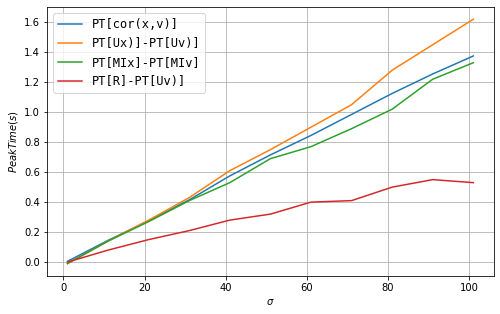

In [20]:
plt.plot(Gsigma_list,np.array(xvt_cor_list)/2)
plt.plot(Gsigma_list, np.array(UIx_peaktime)-np.array(UIv_peaktime))
plt.plot(Gsigma_list, np.array(MIx_peaktime)-np.array(MIv_peaktime))
# plt.plot(Gsigma_list, np.array(UIx_peaktime)-np.array(Rdn_peaktime))
plt.plot(Gsigma_list, -np.array(UIv_peaktime)+np.array(Rdn_peaktime))
plt.grid()
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$Peak Time (s)$')
plt.legend( ('PT[cor(x,v)]', 'PT[Ux)]-PT[Uv)]', 'PT[MIx]-PT[MIv]', 'PT[R]-PT[Uv)]'), loc='best', prop={'size': 'large', 'family': 'monospace'})
plt.gcf().set_size_inches(8, 4*(np.sqrt(5)-1))

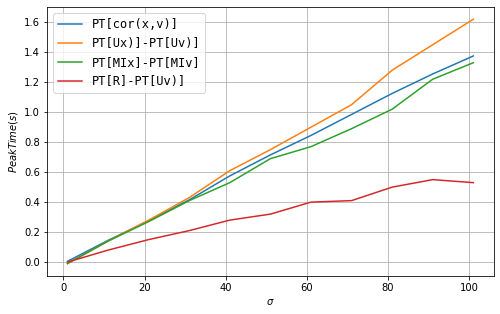

In [21]:
if OX == 'RN':
    plt.plot(Gsigma_list,np.array(xvt_cor_list)/2)
    plt.plot(Gsigma_list, np.array(UIx_peaktime)-np.array(UIv_peaktime))
    plt.plot(Gsigma_list, np.array(MIx_peaktime)-np.array(MIv_peaktime))
    # plt.plot(Gsigma_list, np.array(UIx_peaktime)-np.array(Rdn_peaktime))
    plt.plot(Gsigma_list, -np.array(UIv_peaktime)+np.array(Rdn_peaktime))
    plt.grid()
    plt.xlabel(r'$\sigma$')
    plt.ylabel(r'$Peak Time (s)$')
    plt.legend( ('PT[cor(x,v)]', 'PT[Ux)]-PT[Uv)]', 'PT[MIx]-PT[MIv]', 'PT[R]-PT[Uv)]'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    plt.gcf().set_size_inches(8, 4*(np.sqrt(5)-1))
elif OX == 'OU':
    plt.plot(Fc_list[:-1], np.array(xvt_cor_list[:-1])/2)
    plt.plot(Fc_list[:-1], np.array(UIx_peaktime[:-1])-np.array(UIv_peaktime[:-1]))
    plt.plot(Fc_list[:-1], np.array(MIx_peaktime[:-1]-np.array(MIv_peaktime[:-1])))
    plt.plot(Fc_list[:-1], -np.array(UIv_peaktime[:-1])+np.array(Rdn_peaktime[:-1]))
    plt.grid()
    plt.xlabel(r'$F_c$')
    plt.ylabel(r'$Peak Time (s)$')
    plt.legend( ('PT[cor(x,v)]', 'PT[Ux)]-PT[Uv)]', 'PT[MIx]-PT[MIv]', 'PT[R]-PT[Uv)]'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    plt.gcf().set_size_inches(8, 4*(np.sqrt(5)-1))